In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [13]:
### setup ###

### imports

import random
import sys
sys.path.append('/Users/kszczepaniak/Code/phage-pipeline-env/phage-pipeline')
import submodules.pdf.domain_split as ds
from lib_phage.clustering import cluster_proteins
from lib_phage.utils import setup_dir_tree, fetch_and_rename_protein_ids, build_hhr_table
from lib_phage.logs import check_input_repr_prot_selection, validate_output_repr_prot_selection
from lib_phage.logs import check_input_all_vs_all_HMM, save_params_hhblits, validate_output_hhblits
from lib_phage.logs import validate_create_db, validate_search_all_vs_all, validate_input_ECF, validate_output_ECF
from lib_phage.prot_compare import save_individual_seqs, run_hhblits, build_hh_db, run_all_vs_all
from lib_phage.ecf_finder_wrapper import load_and_filter_data, store_scan_results

### paths

# data sources

cds_all_filepath = '/Users/kszczepaniak/Data/Phage/Rafal_Dropbox/data/input/combined/coding-seqs/cds-aa.fa.gz'

# work dirs
work_dir = '/Users/kszczepaniak/Data/Phage/phage-pipeline-workdir-dev/'
setup_dir_tree(work_dir)

# binaries and libraries

mmseqs_binpath  = 'mmseqs'
uniref_db_path  = '/Users/kszczepaniak/Data/Phage/db/UniRef30_2020_06/UniRef30_2020_06'
hhsuite_bins    = '/Users/kszczepaniak/Tools/hh-suite/build/bin'
hhsuite_scripts = '/Users/kszczepaniak/Tools/hh-suite/build/scripts'

/tmp/ directory already set up
/tmp/repr-proteins/ directory already set up
/tmp/mmseqs/ directory already set up
/tmp/all-by-all/ directory already set up
/tmp/all-by-all/individual-seqs/ directory already set up
/output/ directory already set up
/output/prot-families/ directory already set up
/output/prot-families/representative/ directory already set up
/output/prot-families/all-by-all/ directory already set up
/intermediate/ directory already set up
/intermediate/prot-families/ directory already set up
/intermediate/prot-families/profiles/ directory already set up
/intermediate/prot-families/all-by-all/ directory already set up
/intermediate/prot-families/db/ directory already set up
/log/ directory already set up


In [31]:
### Get representative proteins ###

# set clustering params
cluster_params_min_seqid   = 0.3
cluster_params_sensitivity = 7
cluster_params_coverage    = 0.95

# check input files integrity & if this step was already executed:
# if it was warn about data overwrite
if check_input_repr_prot_selection():

    # perform clustering
    clustering_filepath = cluster_proteins(input_fasta_filepath=cds_all_filepath,
                                           output_dirpath=work_dir + 'output/prot-families/representative',
                                           mmseqs_tempdir=work_dir + 'tmp/mmseqs',
                                           cluster_params_min_seqid=cluster_params_min_seqid,
                                           cluster_params_sensitivity=cluster_params_sensitivity,
                                           cluster_params_coverage=cluster_params_coverage,
                                           verbose=True)

    no_repr_prot, name_table_filepath = fetch_and_rename_protein_ids(work_dir, clustering_filepath, cds_all_filepath)

    # verify output and save log file
    validate_output_repr_prot_selection(work_dir=work_dir,
                                        output_dirpath=work_dir + 'output/prot-families/representative',
                                        cluster_params_min_seqid=cluster_params_min_seqid,
                                        cluster_params_sensitivity=cluster_params_sensitivity,
                                        cluster_params_coverage=cluster_params_coverage)

Creating db... Done!
Clustering... Done!
Generating a clustering table... Done!
DEVEL: Restricting input to 16 proteins for fast calculation
Validation success, log file stored.


In [32]:
### Perform all vs all comparison ###
# create profiles for each protein with hhblits #

# set create profiles params
cpu  = 2
n    = 1
mact = 0.35
p    = 90
qid  = 10
cov  = 10

# validate previous step
if check_input_all_vs_all_HMM(work_dir=work_dir):

    # execute current step
    save_individual_seqs(work_dir=work_dir)

    run_hhblits(work_dir=work_dir, hhsuite_bins=hhsuite_bins, hhsuite_scripts=hhsuite_scripts, cpu=cpu, 
                uniref_db_path=uniref_db_path, n=n, mact=mact, p=p, qid=qid, cov=cov)

    # save params to log
    save_params_hhblits(work_dir=work_dir, n=n, mact=mact, p=p, qid=qid, cov=cov)

This step was already executed. Run validation fucntion with force=True to overwrite.


In [33]:
# Build db #

# validate previous step
if validate_output_hhblits(work_dir):
    
    # execute current step
    build_hh_db(work_dir=work_dir, hhsuite_bins=hhsuite_bins,
                hhsuite_scripts=hhsuite_scripts, verbose=True)

Database already exists. Overwrite? [y/n]y
Database cleaned.
Concatenated a3m alignments.
Created HMM profiles.
Created column state (CS) sequence database.
DB sorted.
DB successfuly created.


In [157]:
# search all vs all #

# set all vs all search params
cpu  = 2
n    = 1
p    = 90

if validate_create_db(work_dir=work_dir):

    run_all_vs_all(work_dir=work_dir, hhsuite_bins=hhsuite_bins, 
                   hhsuite_scripts=hhsuite_scripts, cpu=cpu, n=n, p=p)

Parameters saved, log file stored.


In [26]:
# create results table #

# check if previous step complete
if validate_search_all_vs_all(work_dir):
    
    # create results table
    build_hhr_table(work_dir)


PARAMS 0.5 2
[46, 161]
[111, 164]
[135, 168]
[46, 115]


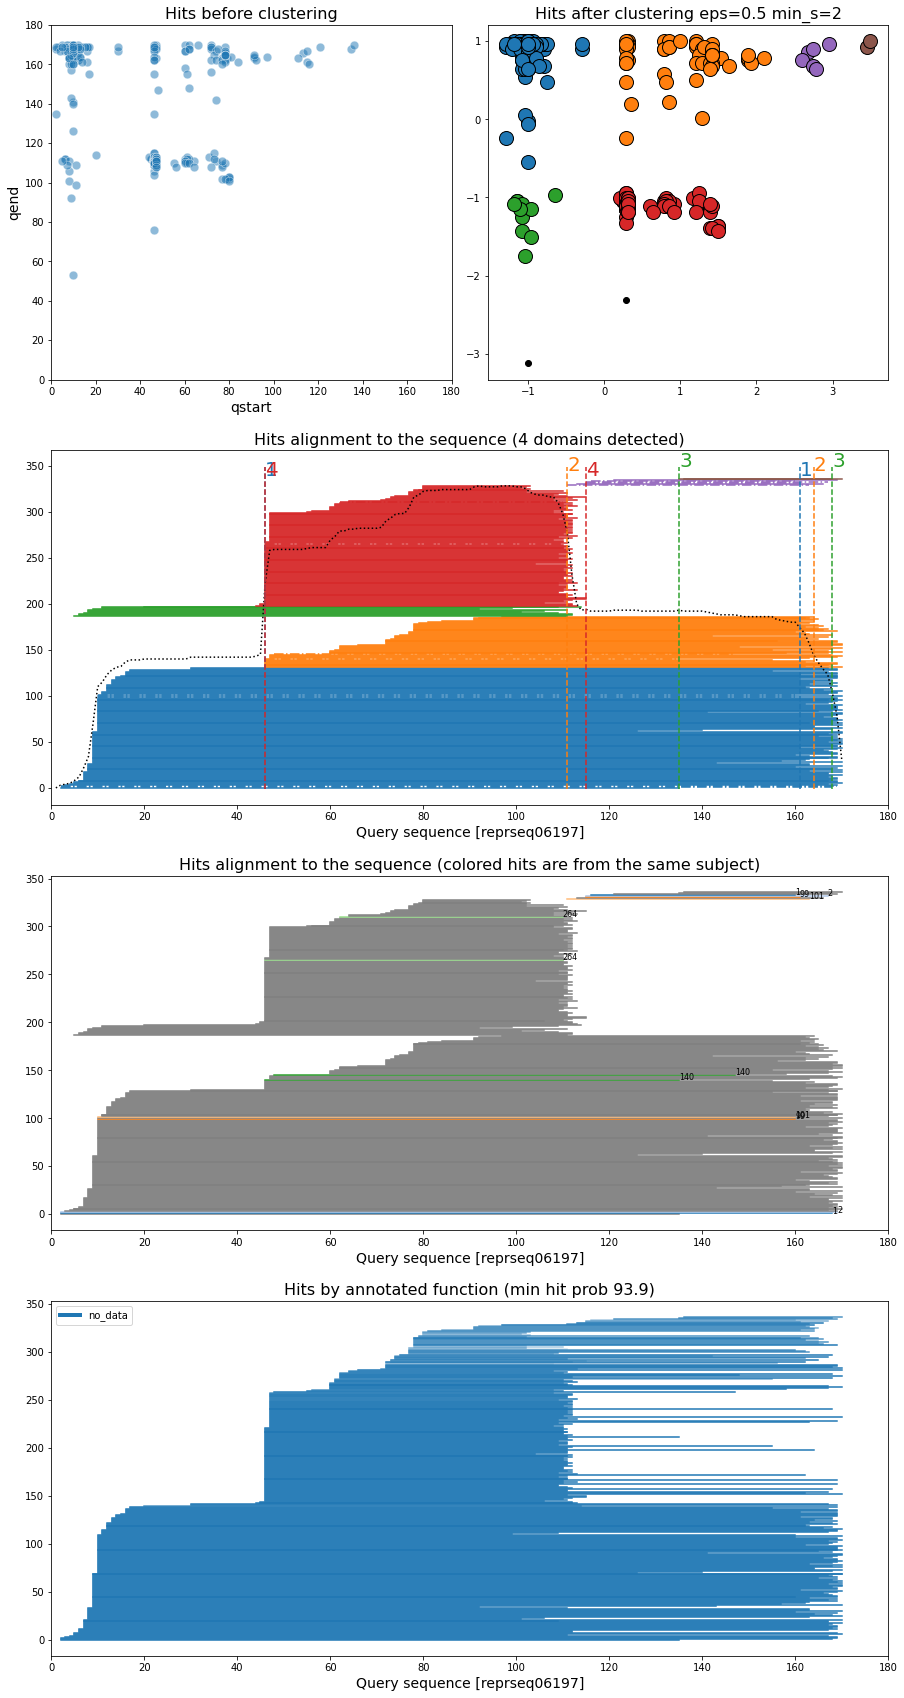

In [37]:
### Analysis - find ECFs ###

# set input/output paths
dataset_name = 'data_260221' # write your custom name (appended to the results files)
ecf_runmode  = 'benchmark' # options: 'benchmark' or 'scan'

# set data filtering params
prob_threshold  = 95.0
eval_threshold  = 1e-03
coverage_cutoff = 0.1 # minimal coverage of hit to total query length
filters_params  = {'prob_threshold':prob_threshold, 'eval_threshold':eval_threshold, 'coverage_cutoff':coverage_cutoff}
# set filters that will be applied
# available filters: prob, eval, self, cov, self-full
filters_used   = ['eval', 'self-full', 'cov']

# algorithm: clustering - for full scan mode
clust_eps        = 0.5 # clustering epsilon parameter
clust_min_sample = 1 # minimum number of samples to create cluster
# algorithm: clustering - for benchmark mode
eps_list         = [0.5]
min_samples_list = [2]

# algorithm: general
min_coverage   = 0.1 # minimal hit coverage at positions to consider it a domain in all steps of algorithm
domain_min_len = 0.05 # minimal length [fraction of full query length] of domain that can be annotated
# algorithm: similiar domains merge
merge_size_cutoff   = 0.9 # ratio of domain1/domain2 and domain2/domain1 must be no smaller than this fraction
merge_shared_cutoff = 0.9 # ratio of set of common positions to set of union of positions must be no smaller than this fraction
# algorithm: steps options
steps = {'merge_similiar': True, # if True then similiar regions will be merged according to params above
         'resolve_no_domain': False # if True then regions with high coverage of hits and without domains will be annotated as domains at the end of algorithm
}

if validate_input_ECF(work_dir):
    
    # apply data filtering
    hhr_table, annotation_table, dataset_size, id_width = load_and_filter_data(work_dir, filters_used, filters_params)
    hhr_table = ds.annot.add_function_column_to_df(hhr_table, annotation_table, no_data=True) # annotation not ready for new set

    # perform ECF search
    if ecf_runmode == 'benchmark':
        
        # to create random sample    
        sample = random.sample(range(1,dataset_size), 10)
        benchmark_set = {'random': { i:{} for i in sample } }
        
        # define protids to scan
        benchmark_set = {'random': {6197: {}}}

        for funct in benchmark_set.keys():
            benchmark_result = ds.funct.run_benchmark(benchmark_set[funct], hhr_table, eps_list=eps_list, id_width=id_width,
                                             min_samples_list=min_samples_list, only_get_plots=True, plot_type='show',
                                             names_dict={}, clustering_pngs_dirpath=work_dir + 'output/ecf-search/plots',
                                             min_coverage=min_coverage, domain_min_len=domain_min_len, 
                                             merge_size_cutoff=merge_size_cutoff, merge_shared_cutoff=merge_shared_cutoff,
                                             dataset_name=dataset_name, db_tables={}, steps=steps, prefix_id='reprseq')

    elif ecf_runmode == 'scan':
        
         ### !!!! DEV - cut list to get faster devel computation
        import random
        ids = list(hhr_table['qname'].unique())
        rp = random.sample(ids, 300)
        hhr_table = hhr_table[hhr_table['qname'].isin(rp)]
        ### !!! END-DEV
        
        ECFs_results = ds.funct.run_domain_finder(hhr_table, clust_eps, clust_min_sample, min_coverage, 
                                                   domain_min_len, merge_size_cutoff, merge_shared_cutoff,
                                                   steps)
        store_scan_results(work_dir, ECFs_results)

    # verify output and save log file
    validate_output_ECF(work_dir, ecf_runmode, filters_params, filters_used, clust_eps, clust_min_sample, 
                        min_coverage, domain_min_len, merge_size_cutoff, 
                        merge_shared_cutoff, steps)

